In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy import arange, array, exp, integrate
from physoce import tseries as ts
import gsw

def neureg(x,y):
    #x,y are numpy arrays
    #subtract mean to make zero mean:
    xn = x - np.mean(x)
    yn = y - np.mean(y)
    #perform neutral regression for comparison, e.g. Garrett and Petrie 1981 and Kirincich et al 2005
    an = np.sqrt(((st.tvar(yn)))/((st.tvar(xn)))) #find slope
    bn = (np.mean(y) - an*np.mean(x)) #find intercept
    rn = np.sum(x*y)/np.sqrt((np.sum(x**2)*np.sum(y**2))) #find correlation coefficient
    slope_err = an*np.sqrt((1-rn**2)/len(x)) #compute std err in slope = a*sqrt((1-r^2)/n)
    #compute std err in intercept = vary^.5*sqrt((1-r^2)/n*(1+xmean^2/var(x))) 
    #(e.g., Miller & Kahn 1962, Statistical Analysis in the Geological Science)
    #https://stats.stackexchange.com/questions/391112/standard-error-of-coefficient-estimates-for-model-ii-regression
    inter_err = np.sqrt(st.tvar(yn))*np.sqrt(((1-rn**2)/len(x))*(1+np.mean(x)**2/st.tvar(xn))) 
    return an,bn,rn,slope_err,inter_err

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [4]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

zero = np.zeros(len(ds['time']))

In [5]:
ncfile_prof = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml'
ds_no3 = xr.open_dataset(ncfile_prof+'#fillmismatch')

In [6]:
ds_no3 = ds_no3.swap_dims({'obs':'time'})

In [7]:
ds_no3.load()

<xarray.Dataset>
Dimensions:                                 (time: 14288, wavelength: 256)
Coordinates:
  * wavelength                              (wavelength) int32 0 1 2 ... 254 255
    obs                                     (time) int32 0 1 2 ... 14286 14287
  * time                                    (time) datetime64[ns] 2019-05-29T...
    pressure                                (time) float64 18.85 ... 0.9342
    lat                                     (time) float64 44.66 44.66 ... 44.66
    lon                                     (time) float64 -124.1 ... -124.1
Data variables: (12/56)
    profiler_timestamp                      (time) datetime64[ns] 2019-05-29T...
    nutnr_spectrum_average                  (time) float32 1.82e+04 ... 1.708...
    nutnr_fit_base_2                        (time) float32 -1.738 ... -2.3
    nutnr_fit_base_1                        (time) float32 5.111 4.71 ... 9.646
    year                                    (time) float32 2.019e+03 ... 2.01...
    ctd_psu                                 (time) float32 -1.0 -1.0 ... -1.0
    ...                                      ...
    ctd_temp_qc_results                     (time) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_executed                    (time) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_results                     (time) float32 0.0 0.0 ... 0.0 0.0
    salinity_corrected_nitrate_qc_executed  (time) float32 29.0 29.0 ... 29.0
    salinity_corrected_nitrate_qc_results   (time) float32 13.0 13.0 ... 29.0
    spectral_channels                       (time, wavelength) float32 593.0 ...
Attributes: (12/70)
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             nutnr_j_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    DODS.strlen:                        18
    DODS.dimName:                       string18

In [8]:
ds.load()

<xarray.Dataset>
Dimensions:                         (bin: 30, obs: 8921)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * obs                             (obs) int32 0 1 2 3 ... 8917 8918 8919 8920
Data variables: (12/49)
    ensemble_number                 (obs) float32 11.0 12.0 ... 8.931e+03
    transducer_depth                (obs) float32 230.0 233.0 ... 247.0 248.0
    pitch                           (obs) float32 -40.0 -46.0 ... -337.0 -322.0
    cell_length                     (obs) float32 100.0 100.0 ... 100.0 100.0
    driver_timestamp                (obs) datetime64[ns] 2019-11-22T23:55:15....
    id                              (obs) |S64 b'd96e4e64-3eda-4f65-ad69-587a...
    ...                              ...
    corrected_echo_intensity_beam4  (obs, bin) float64 67.5 68.4 ... 24.75 23.85
    eastward_seawater_velocity      (obs, bin) float64 0.0781 ... -0.08853
    northward_seawater_velocity     (obs, bin) float64 0.08675 0.1105 ... -0.915
    upward_seawater_velocity        (obs, bin) float64 0.018 0.02 ... -0.002
    error_seawater_velocity         (obs, bin) float64 0.046 0.033 ... 0.1 nan
    bin_depths                      (obs, bin) float64 20.91 19.91 ... -5.3 -6.3
Attributes: (12/72)
    node:                               MFD35
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.65683
    lon:                                -124.09533
    DODS.strlen:                        18
    DODS.dimName:                       string18

In [11]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

In [29]:
good = (ds['bin_depths'] > 3)

here we perform filtering on raw u,v data from dataset before applying additional depth averages and principal axis analysis

In [30]:
#to perform filtering, first assign new data array with pl64 applied to each cross shore/along shore data
#then merge this data array with the main dataset
temp = xr.DataArray(ts.pl64(ds['u'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='u_fil')
ds = ds.merge(temp)
temp = xr.DataArray(ts.pl64(ds['v'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='v_fil')
ds = ds.merge(temp)

after obtaining filtered data, now perform depth average and rotate into principal axis

In [31]:
uda = ts.depthavg(ds['u_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds['uda'],ds['vda'])
ds['cs_da'],ds['as_da'] = rot(ds['uda'],ds['vda'],-theta+90)

t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-30 00:00:00')

Now time to work on finding baroclinic u, with depth average removed and filter applied.

Taking baroclinic crossshore velocity as the filtered velocity minus (should it be plus?) the depth average.

In [32]:
ds['cs_fil'],ds['as_fil'] = rot(ds['u_fil'],ds['v_fil'],-theta+90)
ds['cs_bar'] = ds['cs_fil'] - ds['cs_da']
ds['as_bar'] = ds['as_fil'] - ds['as_da']

In [12]:
dt_str = '0.5H'  # string indicating time averaging frequency
dt = pd.to_timedelta(dt_str)   # time averaging frequency as timedelta
tmin = ds_no3['time'][0].dt.round(dt_str)    # round start date
tmax = ds_no3['time'][-1].dt.round(dt_str)   # round end date
time_grid = ds['time'].values   # array of dates

In [13]:
good_bin = (ds['bin_depths_avg'] < 0)
pmin = 0  # minimum pressure
pmax = np.max(ds_no3['pressure'])   # maximum pressure
dp = 1   # pressure averaging interval
pressure_grid = np.flip(-ds['bin_depths_avg'].values) # center of pressure bins
pressure_bins = np.zeros(len(pressure_grid)+1) # edges of pressure bins
pressure_bins[0] = pressure_grid[0] - dp/2
pressure_bins[-1] = pressure_grid[-1] + dp/2
for i in range(len(pressure_bins)-2):
    pressure_bins[i+1] = np.average([pressure_grid[i],pressure_grid[i+1]])
#for i in range(len(pressure_bins)-1):
#    pressure_grid.append(np.average([pressure_bins[i],pressure_bins[i+1]]))  # center of pressure bins
#pressure_grid = np.array(pressure_grid))


In [14]:
pressure_bins

array([-7.52025832, -6.52025832, -5.52025832, -4.52025832, -3.52025832,
       -2.52025832, -1.52025832, -0.52025832,  0.47974168,  1.47974168,
        2.47974168,  3.47974168,  4.47974168,  5.47974168,  6.47974168,
        7.47974168,  8.47974168,  9.47974168, 10.47974168, 11.47974168,
       12.47974168, 13.47974168, 14.47974168, 15.47974168, 16.47974168,
       17.47974168, 18.47974168, 19.47974168, 20.47974168, 21.47974168,
       22.47974168])

In [15]:
pressure_grid

array([-7.02025832e+00, -6.02025832e+00, -5.02025832e+00, -4.02025832e+00,
       -3.02025832e+00, -2.02025832e+00, -1.02025832e+00, -2.02583207e-02,
        9.79741679e-01,  1.97974168e+00,  2.97974168e+00,  3.97974168e+00,
        4.97974168e+00,  5.97974168e+00,  6.97974168e+00,  7.97974168e+00,
        8.97974168e+00,  9.97974168e+00,  1.09797417e+01,  1.19797417e+01,
        1.29797417e+01,  1.39797417e+01,  1.49797417e+01,  1.59797417e+01,
        1.69797417e+01,  1.79797417e+01,  1.89797417e+01,  1.99797417e+01,
        2.09797417e+01,  2.19797417e+01])

In [16]:
# pre-allocate gridded variable with NaNs
#temperature_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])
nitrate_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])

In [22]:
for i,t in enumerate(time_grid):
    # find dates that fall in interval
    ti, = np.where((ds_no3['time'] >= t - dt/2) & (ds_no3['time'] < t + dt/2))
    nitrate_subset = ds_no3['nitrate_concentration'].isel(time=ti) 
    try:
        nitrate_binned = nitrate_subset.groupby_bins('pressure',pressure_bins).mean()
        nitrate_grid[i,:] = nitrate_binned.values
    except:
        pass

In [28]:
len(nitrate_grid)

8921

In [73]:
cs_bar = np.array(ds['cs_bar'].values)
len(cs_bar)

8921

In [74]:
nflux = np.nan*np.empty([len(nitrate_grid),len(nitrate_grid.T)])

In [75]:
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin
dz

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [86]:
for i in range(len(nitrate_grid)):
    for j in range(len(nitrate_grid.T)):
        if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
            nflux[i][j] = nitrate_grid[i][j] * cs_bar[i][j] * dz[j]

In [87]:
mask = ~np.isnan(nflux.T)

Text(0, 0.5, 'Nitrate Flux [$mmol/s/100m$]')

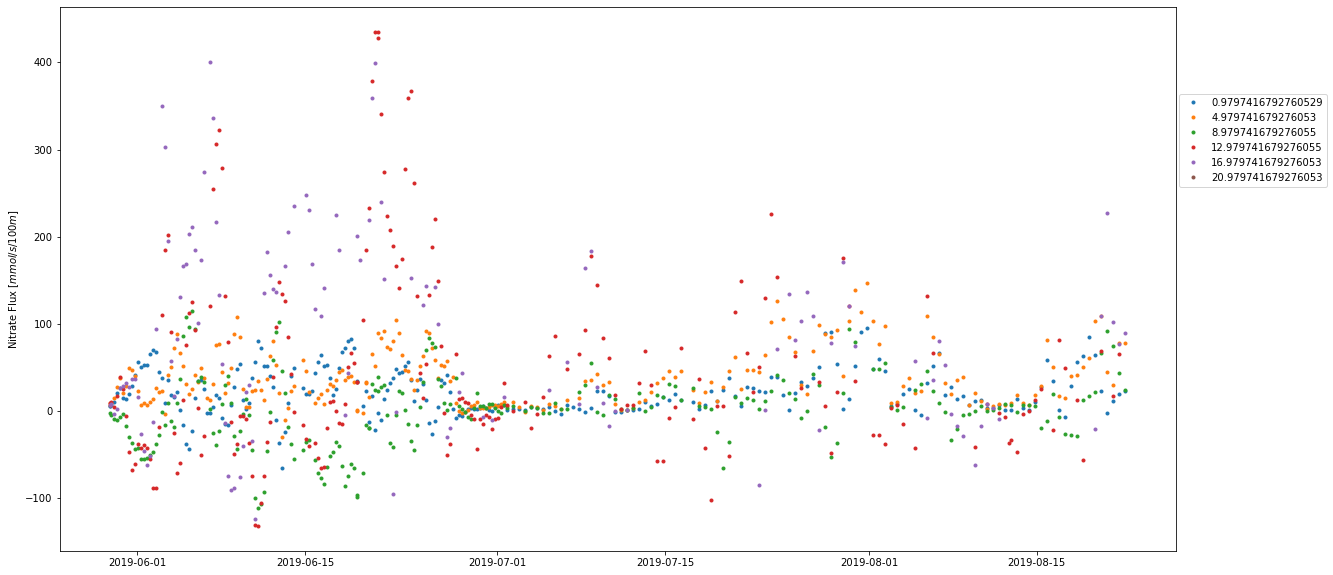

In [89]:
plt.figure(figsize=(20,10))

for i,nf in enumerate(nflux.T):
    if pressure_grid[i] > 0: #only plot below surface
        if i%4 == 0:
            plt.plot(time_grid[mask[i]],nf[mask[i]]*100,'.',label=pressure_grid[i])
plt.legend(bbox_to_anchor=(1.14,.85), loc=1)
plt.ylabel('Nitrate Flux [$mmol/s/100m$]')

In [80]:
for i,nf in enumerate(nflux.T):
    if not np.isnan(nf).all():
        print(nf)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
